# Project 1 (Due Nov 13)

#### GROUP MEMBERS: Isabela Barton, Hayeon Chung, Ben Doniger

**OUR TOPIC**: Chordonomicon: 680,000 chord progressions of popular music songs. Create a chord generator, similar to what we did with Bach in class, but for a particular artist or genre. (https://github.com/spyroskantarelis/chordonomicon)

Submit a document or notebook that clearly addresses the following:

1. Describe the data clearly -- particularly any missing data that might impact your analysis -- and the provenance of your dataset. Who collected the data and why? (10/100 pts)
2. What phenomenon are you modeling? Provide a brief background on the topic, including definitions and details that are relevant to your analysis. Clearly describe its main features, and support those claims with data where appropriate. (10/100 pts)
3. Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts)
4. Either use your model to create new sequences (if the model is more generative) or bootstrap a quantity of interest (if the model is more inferential). (15/100 pts)
5. Critically evaluate your work in part 4. Do your sequences have the properties of the training data, and if not, why not? Are your estimates credible and reliable, or is there substantial uncertainty in your results? (15/100 pts)
6. Write a conclusion that explains the limitations of your analysis and potential for future work on this topic. (10/100 pts)

In addition, submit a GitHub repo containing your code and a description of how to obtain the original data from the source. Make sure the code is commented, where appropriate. Include a .gitignore file. We will look at your commit history briefly to determine whether everyone in the group contributed. (10/100 pts)

In class, we'll briefly do presentations and criticize each other's work, and participation in your group's presentation and constructively critiquing the other groups' presentations accounts for the remaining 15/100 pts.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import music21

In [4]:
url = "https://huggingface.co/datasets/ailsntua/Chordonomicon/resolve/main/chordonomicon_v2.csv"
df = pd.read_csv(url, dtype=str, low_memory=False)

In [5]:
df.head()

,id,chords,release_date,genres,decade,rock_genre,artist_id,main_genre,spotify_song_id,spotify_artist_id
0,1,<intro_1> C <verse_1> F C E7 Amin C F C G7 C F...,NaN,'classic country pop',NaN,NaN,artist_1,pop,NaN,4AIEGdwDzPELXYgM5JaEY5
1,2,<intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs...,2003-01-01,'alternative metal' 'alternative rock' 'nu met...,2000.0,pop rock,artist_2,metal,2ffJZ2r8HxI5DHcmf3BO6c,694QW15WkebjcrWgQHzRYF
2,3,<intro_1> Csmin <verse_1> A Csmin A Csmin A Cs...,2003-01-01,'alternative metal' 'canadian rock' 'funk meta...,2000.0,canadian rock,artist_3,metal,5KiY8SZEnvCPyIEkFGRR3y,0niJkG4tKkne3zwr7I8n9n
3,4,<intro_1> D Dmaj7 D Dmaj7 <verse_1> Emin A D G...,2022-09-23,NaN,2020.0,NaN,artist_4,NaN,01TtAcUqyLCRBZq4ZZiQWS,17BfKBemmMGO5ZAK25wraW
4,5,<intro_1> C <verse_1> G C G C <chorus_1> F Dmi...,2023-02-10,'modern country pop',2020.0,NaN,artist_5,pop,3zUecdrWC3IqrNSjhnoF3G,4GGfAshSkqoxpZdoaHm7ky


In [6]:
#filter to get just the country genre
countrydf = df.query("main_genre == 'country'")
countrydf.shape


(53306, 10)

In [7]:
countrydf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53306 entries, 20 to 642859
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 53306 non-null  object
 1   chords             53306 non-null  object
 2   release_date       44962 non-null  object
 3   genres             53306 non-null  object
 4   decade             44962 non-null  object
 5   rock_genre         15083 non-null  object
 6   artist_id          53306 non-null  object
 7   main_genre         53306 non-null  object
 8   spotify_song_id    47247 non-null  object
 9   spotify_artist_id  53306 non-null  object
dtypes: object(10)
memory usage: 4.5+ MB


In [8]:
countrydf.isna().sum()

id                       0
chords                   0
release_date          8344
genres                   0
decade                8344
rock_genre           38223
artist_id                0
main_genre               0
spotify_song_id       6059
spotify_artist_id        0
dtype: int64

## Question 1: Missing Data, Provenance, and Purpose

The dataset we’re using is a filtered version of the Chordonomicon collection, which contains about 680,000 chord progressions from popular songs. For this project, we focused only on the 53,306 songs labeled as “country.” The full dataset was compiled by Spyridon Kantarelis et al. (2024) as part of a project to help researchers study chord progressions in modern music and to support work on AI-based music generation.

Each record includes details like the artist, genre, song identifiers, release year, and, most importantly, the full chord progression for that song. However, there are some missing values worth noting:
- About 8,000 songs are missing release dates, so any time-trend analysis (like how country chords evolved by decade) would be incomplete.
- Around 38,000 songs don’t list a rock sub-genre label, which makes it harder to look at crossover trends between country and rock.
- Roughly 5,000 songs are missing Spotify IDs, limiting the ability to link external information such as play counts or popularity metrics.

Overall, this dataset provides a really rich view of chord usage patterns across country songs and it offers a great way to model musical structure statistically. 

## Question 2: The Phenomenon Being Modeled

The phenomenon we are modeling is how chords tend to follow one another in country songs (a.k.a. the “patterns” of chord progressions that define the sound of the genre). A chord progression is just the sequence of chords that gives a song its harmonic backbone. In simple terms, we are looking at the probability that one chord follows another and how those probabilities combine to create the feel of a typical country tune.

Using a Markov model, we treat each chord as a discrete state and estimate how likely each chord is to come after the previous one (and, in the second-order case, the previous two). This lets the model “learn” short-term dependencies, kind of like next-word prediction in language models, but for music.

From the data, a few clear trends show up. Country music tends to reuse a small set of chords, things like G, C, D, and Em, which show up far more often than others. These chords frequently appear in short repeating loops (for example, G → C → D), which the model captures well. When visualized as a transition matrix, you can see that some chord-to-chord movements are much more common than others.

Some cleanup was needed before modeling, since chord notation in the dataset wasn’t always consistent (e.g., “G/B,” “Dmaj7,” etc.) and wasn't compatible with the music21 package. We simplified these so that the states were comparable. Even with some missing metadata and messy formatting, the dataset was large enough to produce reliable transition estimates and highlight how repetitive patterns drive much of country music’s harmonic structure.

## Question 3

To model chord transitions in country songs, we counted the number of times each chord was played in each of the country songs, keeping track of which chord was played immediately prior. We then converted the count to proportions and normalized the values to get a transition matrix. This matrix allowed us to see the proportion of time any chord was played after any given starting chord.

Due to the complexities of music, although we started by building a transition matrix that was order 1, we chose to increase to order 2. This meant that our transition matrix now reflected the proportion of time a chord was played, given the 2 chords played previously. This ended up providing us with more realistic results.

Additionally, we chose to represent chords with different base notes as their normal chord in order to reduce the size of the sample space. Without this modification, the sample space was large enough that computing the transition matrix took significantly longer, and the results were harder to interpret.

In [9]:
#get a list of chords for each song, removing tags like <verse_1>
songs = countrydf['chords']
chord_lists = [[chord for chord in song.split() if '<' not in chord] for song in songs]
chord_lists[1]

['E',
 'D/E',
 'E',
 'D/E',
 'E',
 'A',
 'E',
 'A',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'B',
 'A',
 'E',
 'D/E',
 'A',
 'E',
 'D/E',
 'A',
 'E',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'A',
 'B',
 'E/Gs',
 'A',
 'B',
 'E/Gs',
 'A',
 'B',
 'E/Gs',
 'A',
 'B',
 'E/Gs',
 'A',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'E',
 'A',
 'B',
 'E',
 'B',
 'E',
 'B',
 'E',
 'B',
 'D/E',
 'A',
 'E',
 'B',
 'D',
 'E',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'A',
 'B',
 'A']

In [10]:
# tmp = chord_lists[1]
# for i in range(0, len(tmp)):
#     if '/' in tmp[i]:
#         # print(tmp[i])
#         # print(tmp[i].split('/')[0])
#         tmp[i] = tmp[i].split('/')[0]
#         print(tmp[i])
# tmp

# Simplify slash chords by keeping only the main chord (e.g., C/E → C)
for song in chord_lists:
    for i in range(0, len(song)):
        if '/' in song[i]:
            song[i] = song[i].split('/')[0]

chord_lists[1]
        

['E',
 'D',
 'E',
 'D',
 'E',
 'A',
 'E',
 'A',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'B',
 'A',
 'E',
 'D',
 'A',
 'E',
 'D',
 'A',
 'E',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'E',
 'B',
 'Csmin',
 'A',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'A',
 'B',
 'E',
 'A',
 'B',
 'E',
 'A',
 'B',
 'E',
 'A',
 'B',
 'E',
 'A',
 'Csmin',
 'B',
 'A',
 'Csmin',
 'B',
 'A',
 'E',
 'B',
 'E',
 'A',
 'B',
 'E',
 'B',
 'E',
 'B',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'D',
 'E',
 'B',
 'A',
 'E',
 'B',
 'A',
 'E',
 'B',
 'D',
 'A',
 'E',
 'B',
 'A',
 'B',
 'A']

### Order 1

In [11]:
#build state list
states = set()
for i in range(1, len(chord_lists)):
    song_i = set(chord_lists[i])
    states = states.union(song_i)
    
states = list(states)

In [12]:
# states.sort()
len(states)

468

In [13]:
S = len(states)
tr_counts = np.zeros( (S,S) )

#get transition counts
for song in chord_lists:
    seq = np.array(song)
    for t in range(1, len(seq)):
        #current and next tokens
        x_tml = seq[t-1] #previous state
        x_t = seq[t] #current state
        #determine transition indices
        index_from = states.index(x_tml)
        index_to = states.index(x_t)
        #update transition counts
        tr_counts[index_from, index_to] += 1

print('Transition Counts:\n', tr_counts)

Transition Counts:
 [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 12. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [14]:
#get state proportions
sums = tr_counts.sum(axis=0, keepdims=True)
print('State Proportions:\n')
print(sums)

State Proportions:

[[6.00000e+00 1.00000e+00 2.96700e+03 2.00000e+00 1.00000e+00 7.00000e+00
  1.00000e+00 3.80000e+01 1.20800e+03 2.55900e+03 1.66000e+02 1.00000e+00
  6.30000e+01 7.00000e+00 4.92000e+02 4.75000e+02 5.70000e+01 6.30000e+01
  8.20000e+01 4.40000e+01 9.10000e+02 5.15000e+02 6.10000e+01 6.20000e+01
  1.58000e+02 3.80000e+02 7.47000e+02 3.40000e+02 1.20000e+01 9.00000e+00
  4.30000e+01 1.97000e+02 8.00000e+00 2.00000e+00 6.36760e+04 4.00000e+00
  5.00000e+00 1.44000e+02 4.00000e+00 2.42000e+02 1.34000e+02 4.00000e+00
  2.40000e+01 1.00000e+00 2.30000e+01 1.00000e+01 3.60000e+01 1.82450e+04
  1.80000e+01 5.50000e+01 2.00000e+00 1.24800e+03 1.48200e+03 2.44000e+02
  1.50000e+01 1.50000e+01 3.47200e+03 7.00000e+00 2.20000e+01 1.90000e+01
  1.20000e+01 3.00000e+00 9.40000e+01 1.84400e+03 1.28100e+03 1.25900e+03
  3.20000e+02 9.00000e+00 1.21000e+02 1.00000e+00 7.90000e+01 6.95000e+02
  1.69000e+02 6.04000e+02 9.90000e+01 1.50000e+01 3.49480e+04 9.66800e+03
  1.30000e+01 1.55

In [15]:
#normalize the transition count matrix to get proportions
tr_pr = np.divide(tr_counts, sums, out = np.zeros_like(tr_counts), where = sums!=0)

print('Transition Proportions:\n')
tr_df = pd.DataFrame(np.round(tr_pr, 2), columns = states, index = states)
print(tr_df)


Transition Proportions:

           Adim9  Faugmaj7  Dmaj7  Csminadd9  Caugmaj9  A13b  Eb7b9  Fmaj911s  \
Adim9        0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Faugmaj7     0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Dmaj7        0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Csminadd9    0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Caugmaj9     0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
...          ...       ...    ...        ...       ...   ...    ...       ...   
Gsmaj7       0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Abdim7       0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Cminadd11    0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Abmaj9       0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   
Dbsus2       0.0       0.0    0.0        0.0       0.0   0.0    0.0       0.0   

  

### Order 2

In [16]:
#order 2
order = 2
songs = []
for song in chord_lists:
    T = len(song)
    entry = [' '.join(song[(t-order-1):(t-1)]) for t in range(order+1, T)]
    songs.append(entry)

states = set()
for song in songs:
    states = states.union( set(song) )
states = list(states)

print('States:\n', np.array(states))

S = len(states)
tr_counts = np.zeros( (S,S) )

for song in songs:
    seq = np.array(song)
    for t in range(1,len(seq)):
        x_tm1 = seq[t-1] # previous state
        x_t = seq[t] # current state
        index_from = states.index(x_tm1)
        index_to = states.index(x_t)
        tr_counts[index_to, index_from] += 1  # TO, FROM not FROM, TO

sums = tr_counts.sum(axis=1, keepdims=True)
state_props = sums/np.sum(sums)

# And fix the transition probability normalization:
tr_pr = np.divide(tr_counts, sums, 
                 out=np.zeros_like(tr_counts), 
                 where=sums!=0)
print('\nTransition Proportions:\n', tr_pr)

States:
 ['Abmin Amaj7' 'Fadd11 F' 'Amin Fsmin7' ... 'D7 C13' 'Emin Cminadd13'
 'Gno3d Asus2']

Transition Proportions:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


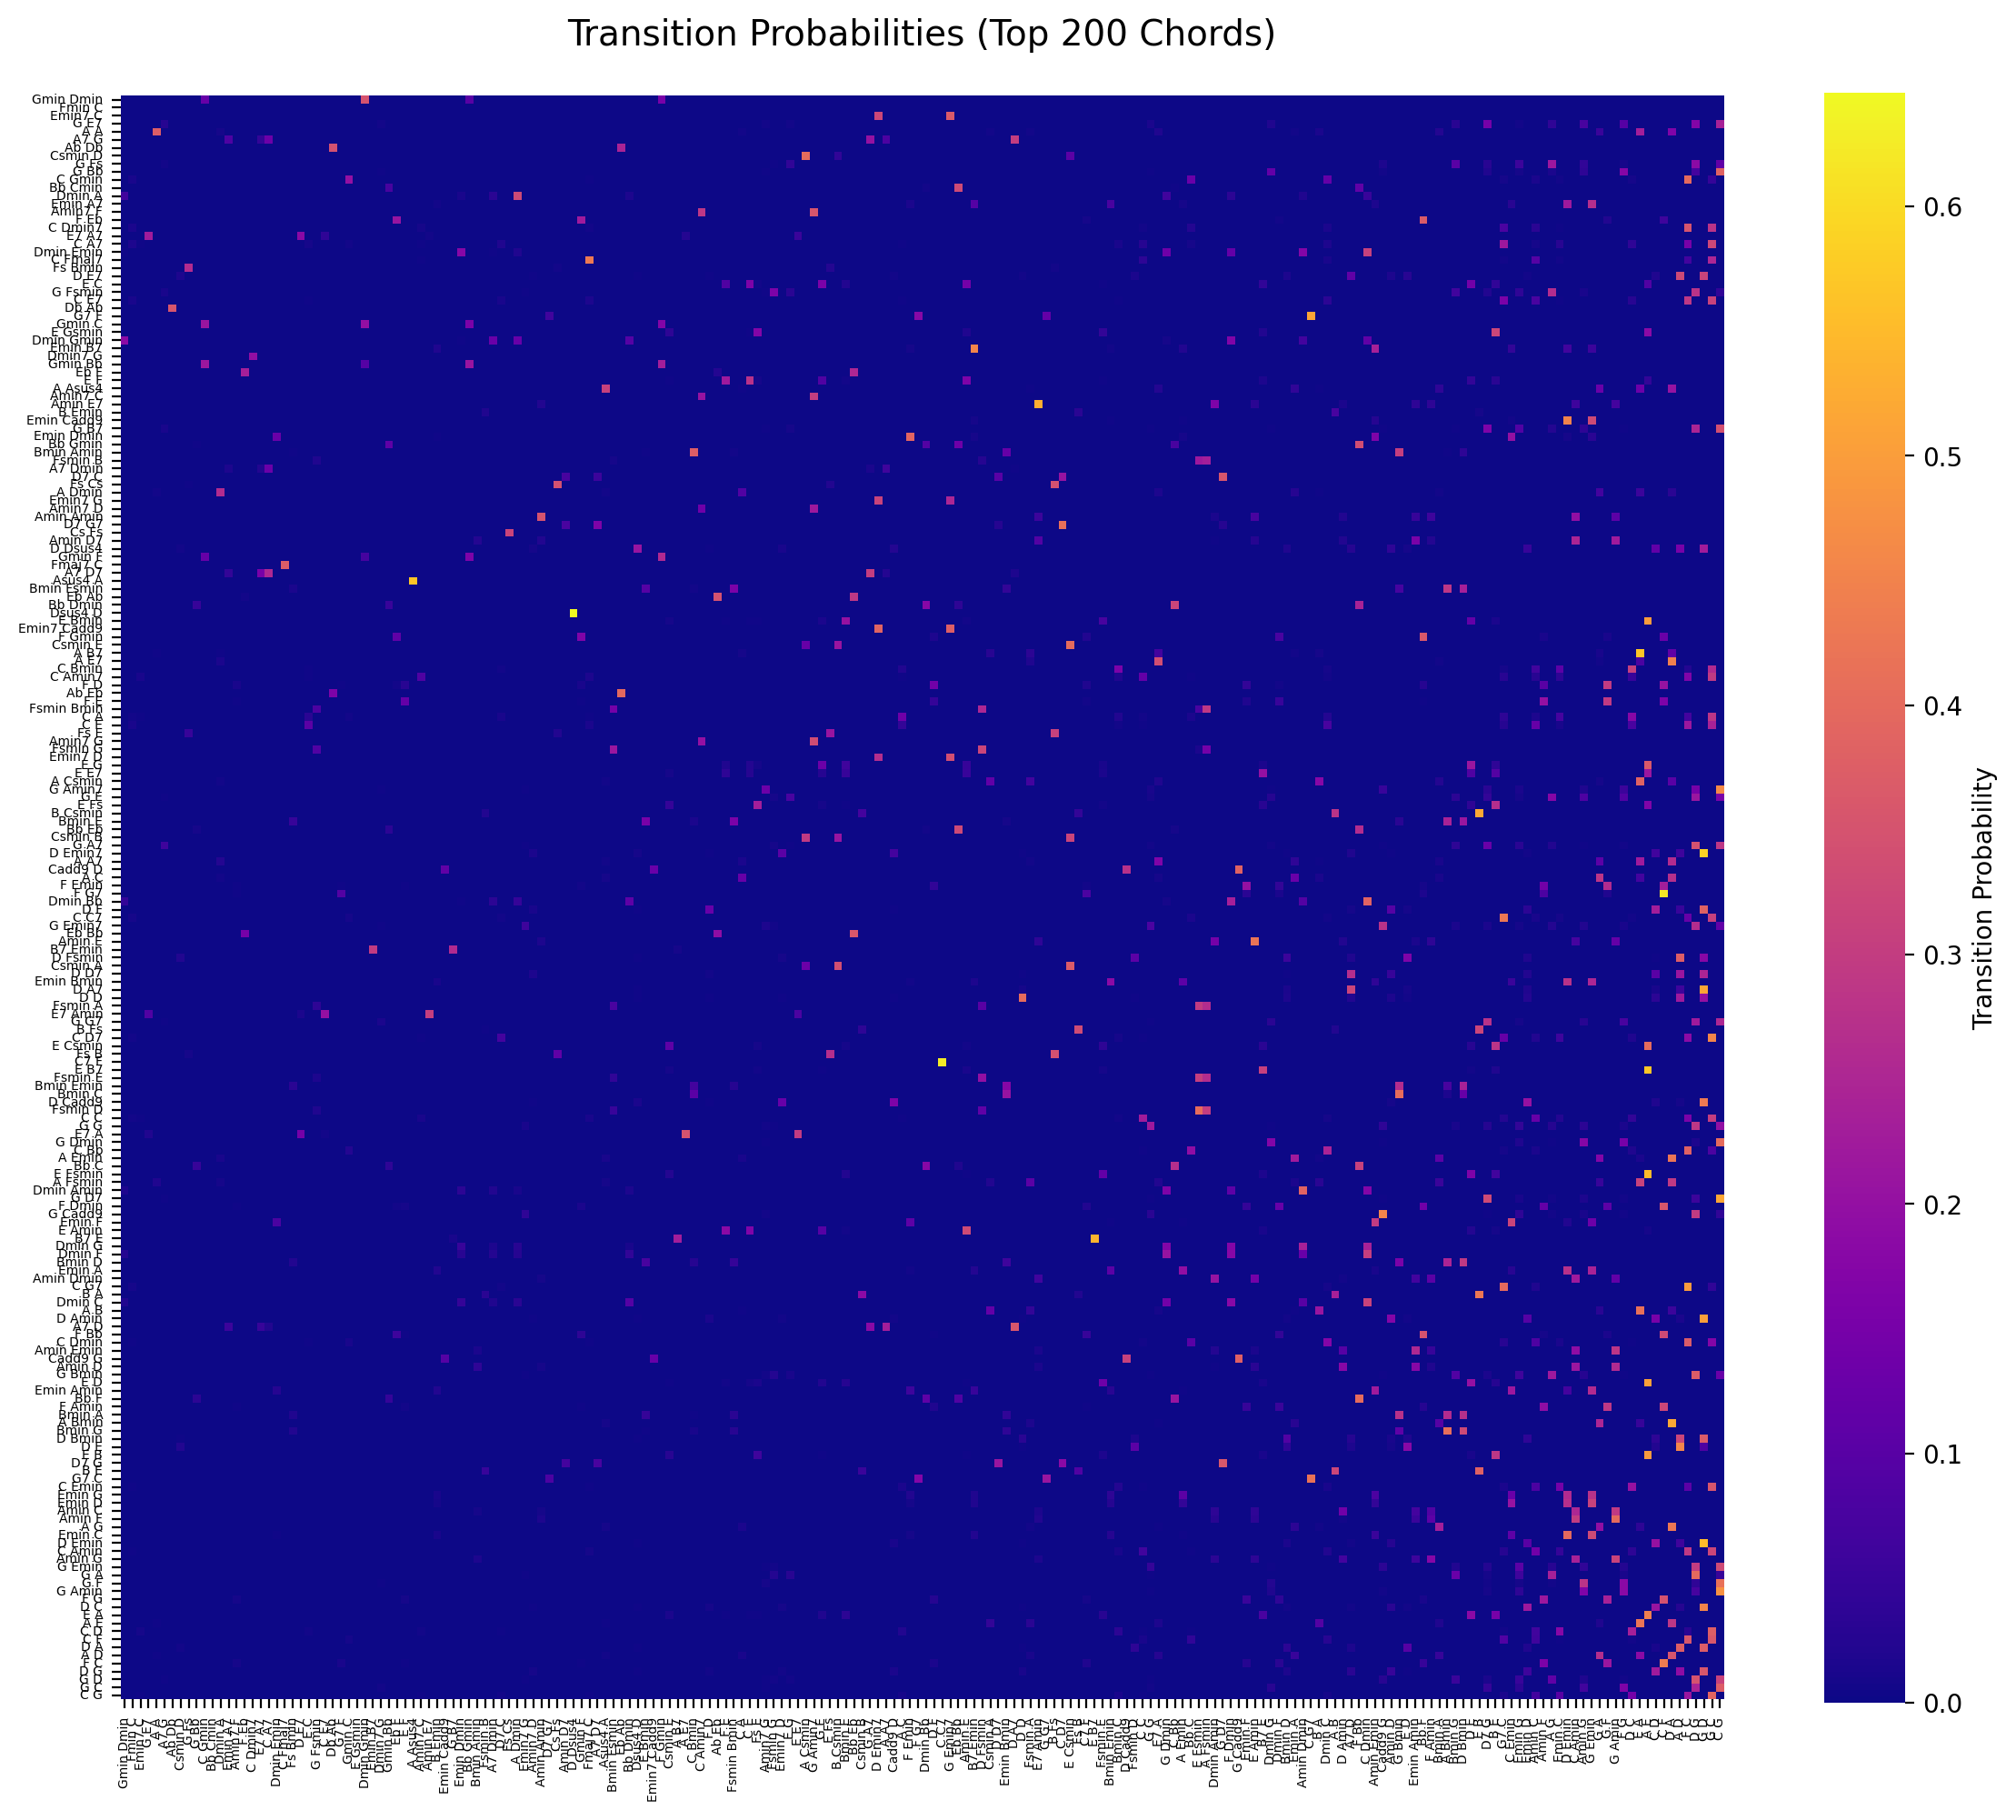

In [17]:
# Count how often each chord appears as "from" or "to"
chord_freq = tr_counts.sum(axis=0) + tr_counts.sum(axis=1)
top_n = 200  # can adjust this
top_indices = np.argsort(chord_freq)[-top_n:]

# Filter both rows and columns for top chords
tr_pr_top = tr_pr[np.ix_(top_indices, top_indices)]
top_states = [states[i] for i in top_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(
    tr_pr_top,
    cmap="plasma",
    square=True,
    xticklabels=top_states,
    yticklabels=top_states,
    cbar_kws={"label": "Transition Probability"}
)
plt.title(f"Transition Probabilities (Top {top_n} Chords)", fontsize=14, pad=20)
plt.xticks(rotation=90, fontsize=5)   
plt.yticks(rotation=0, fontsize=5)    
plt.tight_layout(pad=1.5)
plt.show()


The transition probability heatmap reveals a clear concentration of high-intensity cells along a few dominant chord pairings. This demonstrates that transitions between certain chords occur far more frequently than others. This pattern reflects the repetitive harmonic structures typical of country music where progressions like G → C or D → G act as tonal anchors. The sparse distribution outside the diagonal suggests that less common chord combinations are rare. This reinforces the idea that country songs tend to rely on limited harmonic chord pairings. The heatmap confirms that a small number of strong transitions drive the majority of chord movement in this genre.

/var/folders/6y/d5yr54g90_nbghlfwx83ldb40000gn/T/ipykernel_22924/1724127319.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, x="pair", y="count", palette="crest")


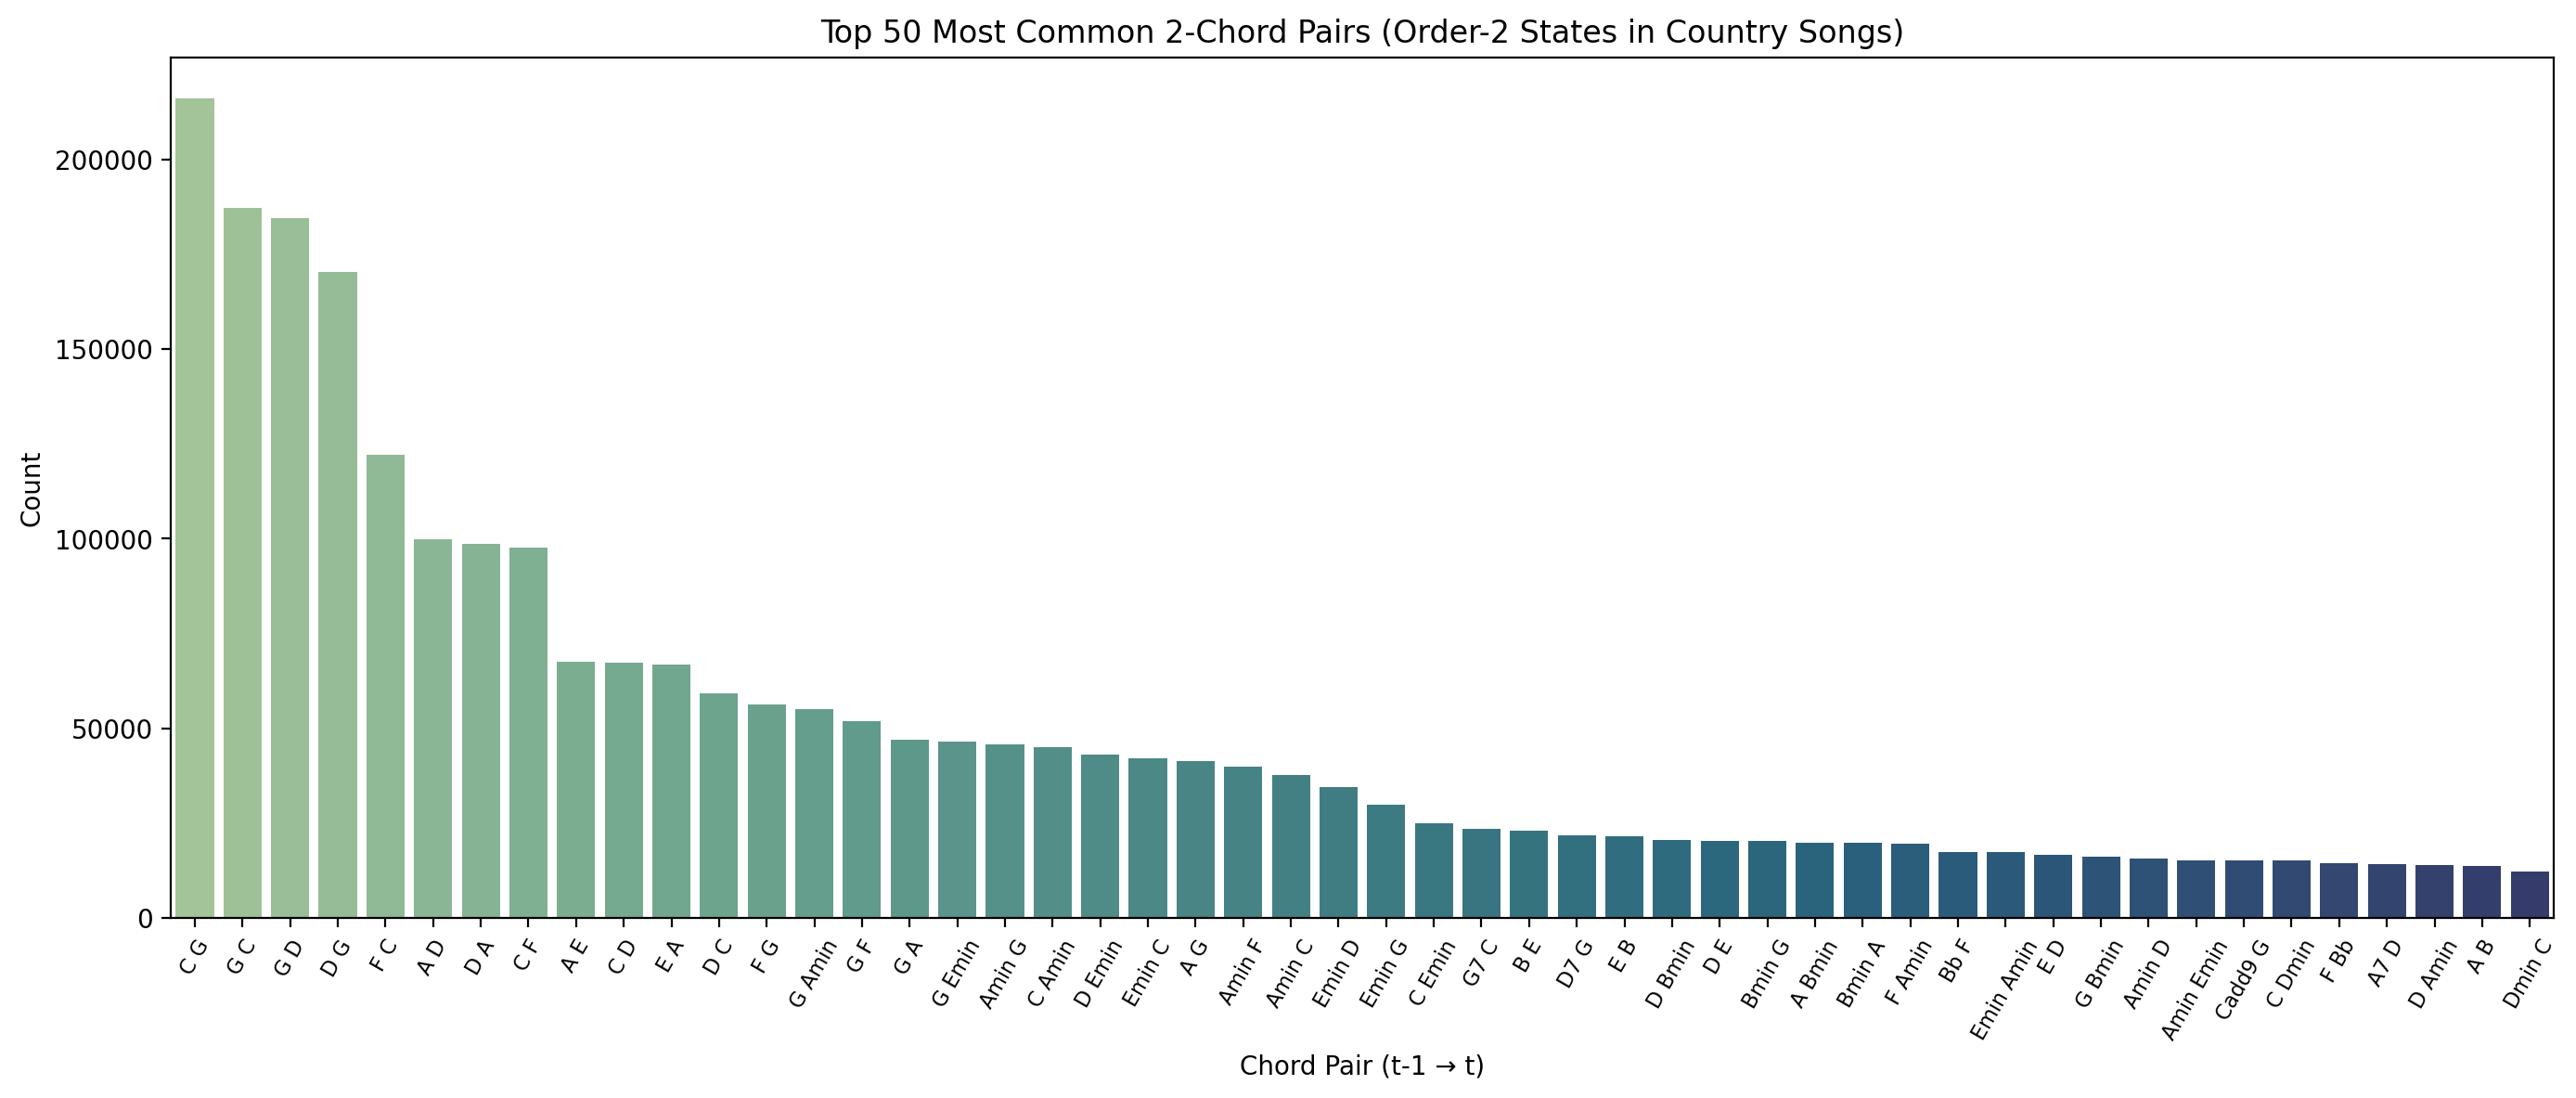

In [18]:
# 2-Chord Pair Histogram 
from collections import Counter

# Flatten all 2-chord states from the 'songs' list
all_pairs = [pair for song in songs for pair in song]

# Count frequency of each 2-chord pair
pair_counts = Counter(all_pairs)

pair_df = (
    pd.DataFrame(pair_counts.items(), columns=["pair", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

# Plot top N most common 2-chord pairs
top_n = 50
top_pairs = pair_df.head(top_n)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_pairs, x="pair", y="count", palette="crest")
plt.title(f"Top {top_n} Most Common 2-Chord Pairs (Order-2 States in Country Songs)")
plt.xlabel("Chord Pair (t-1 → t)")
plt.ylabel("Count")
plt.xticks(rotation=60, fontsize=8)
plt.tight_layout()
plt.show()

The histogram of the most common 2-chord pairs shows that only a handful of transitions dominate the dataset. Frequent pairings such as G C, C D, and D G appear substantially more often than others and captures the cyclical patterns within the genre. This long-tailed distribution emphasizes that while country songs occasionally explore varied harmonies, they overwhelmingly favor familiar two-chord loops that maintain stability and listener familiarity. These results also align with the Markov model’s predictions where high probability states represent the "standard" of country harmony.

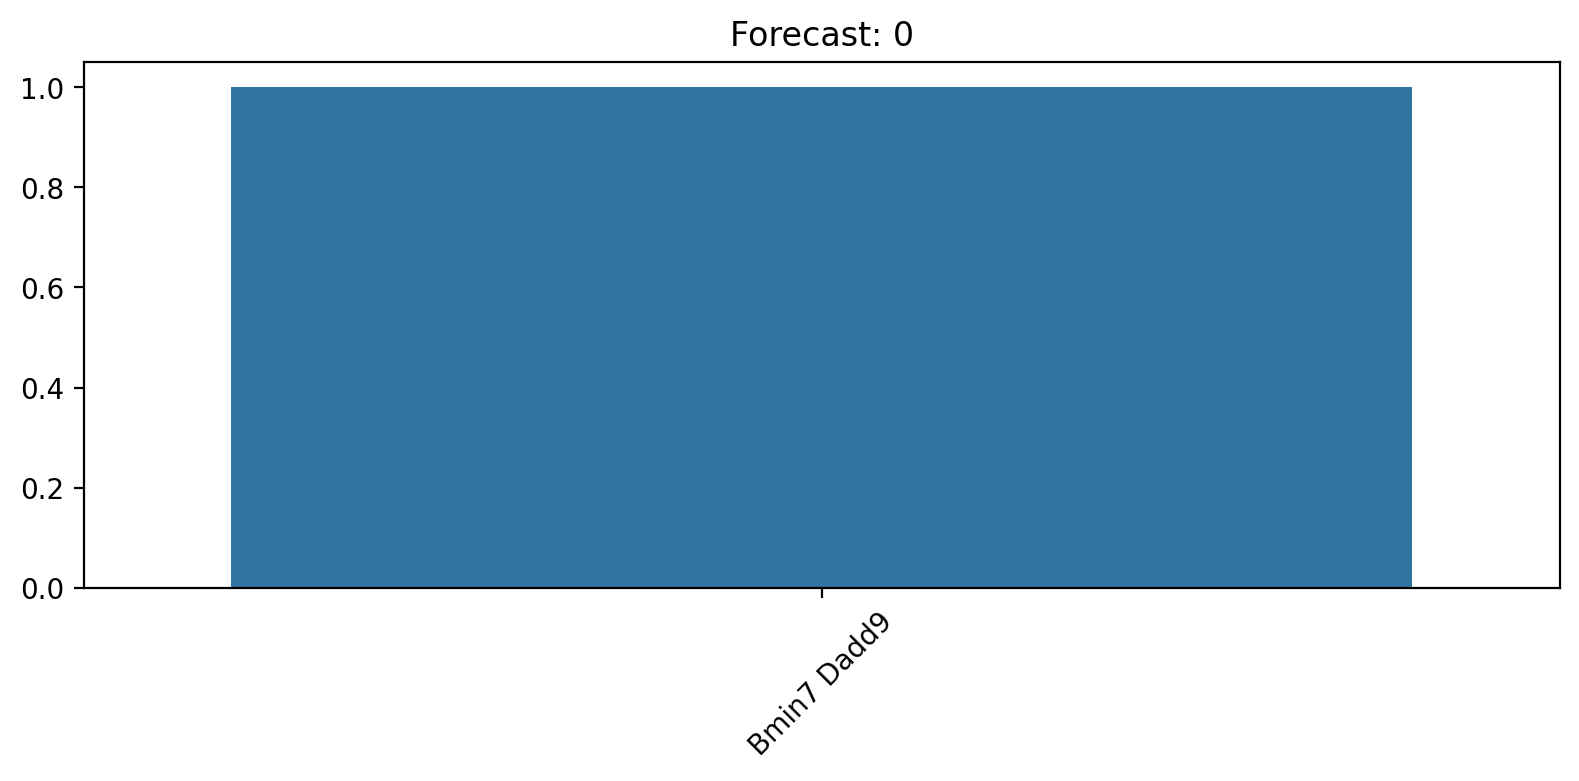

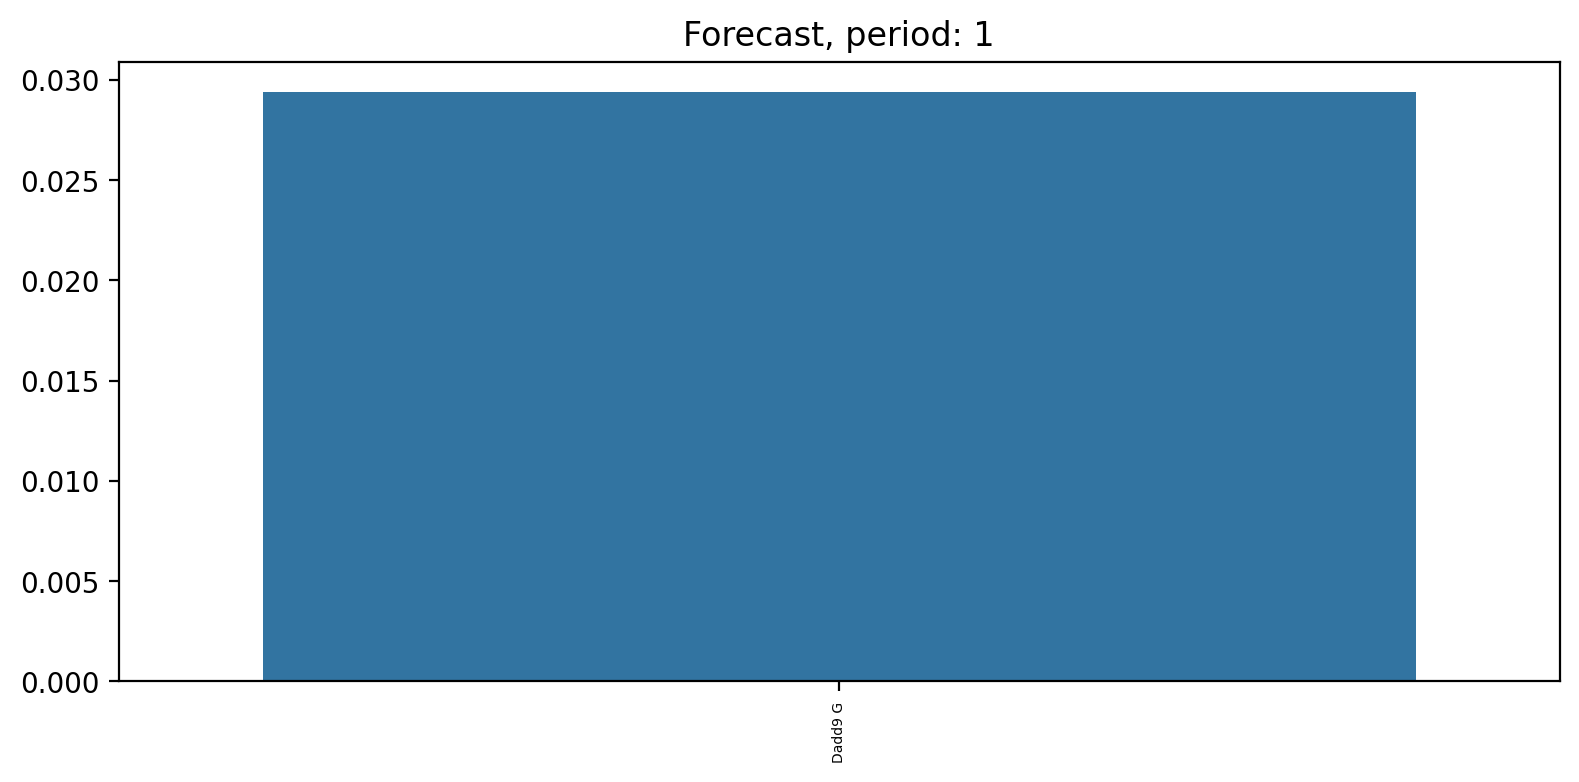

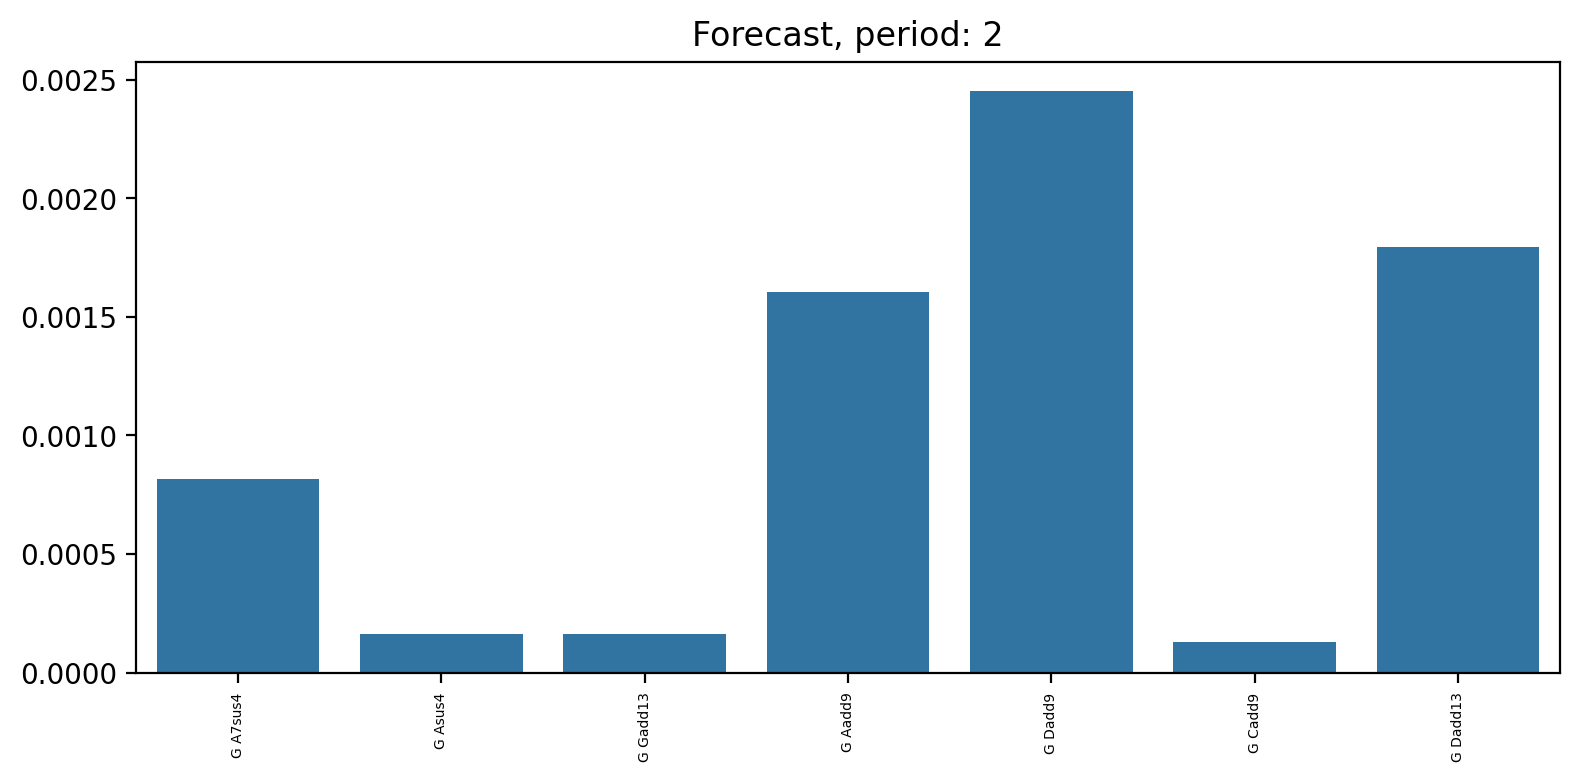

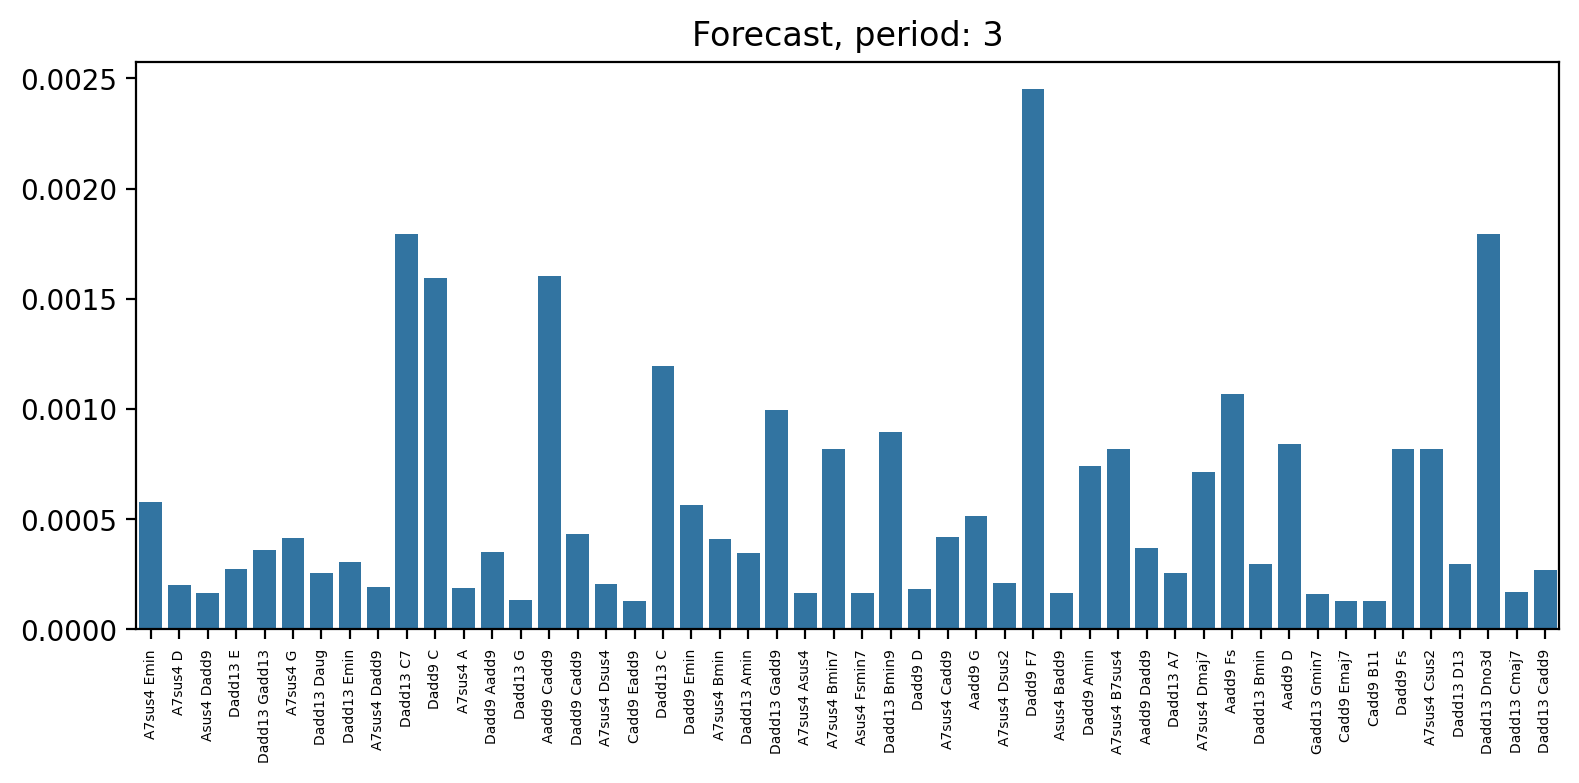

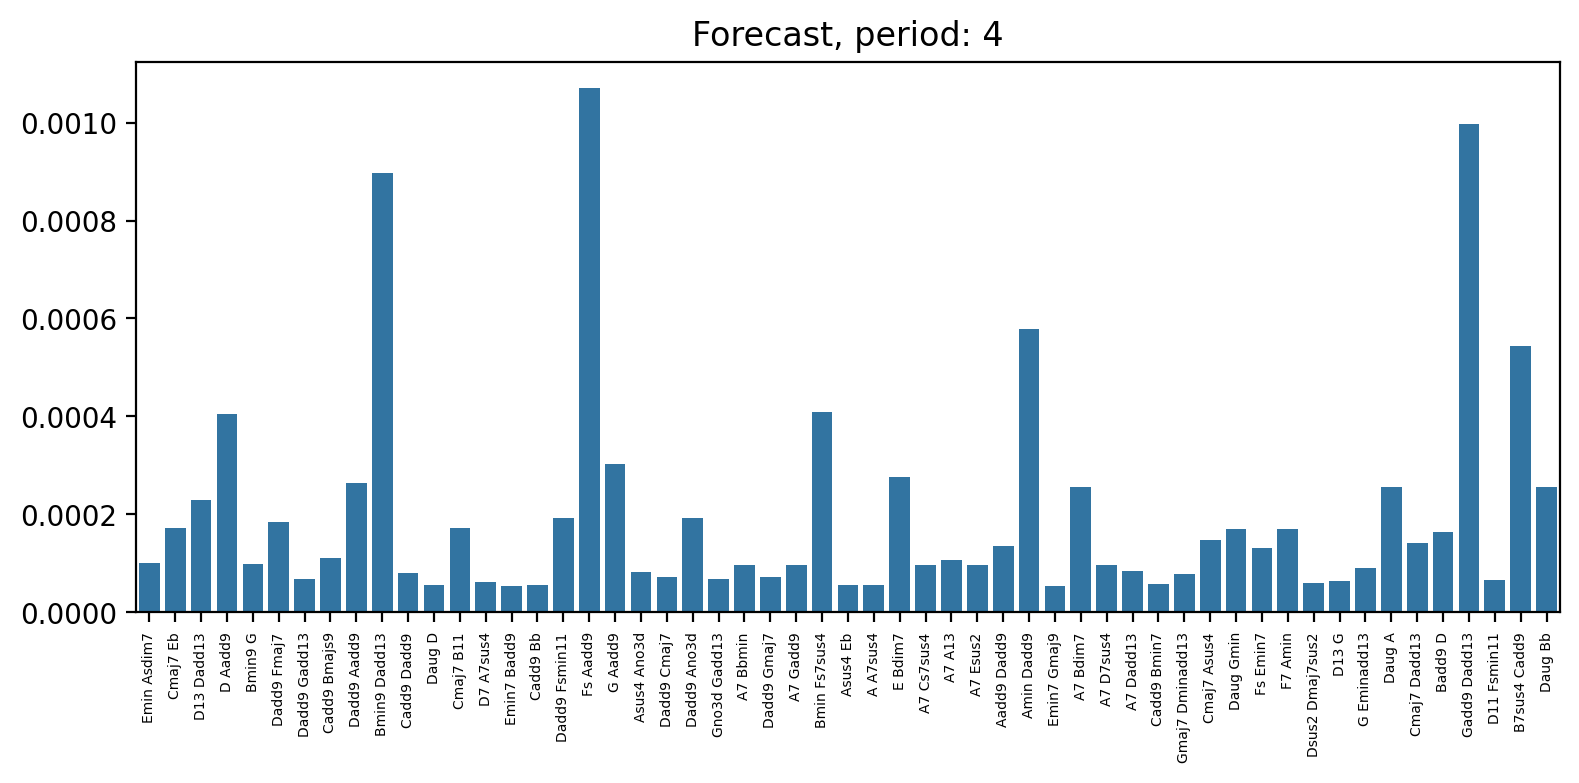

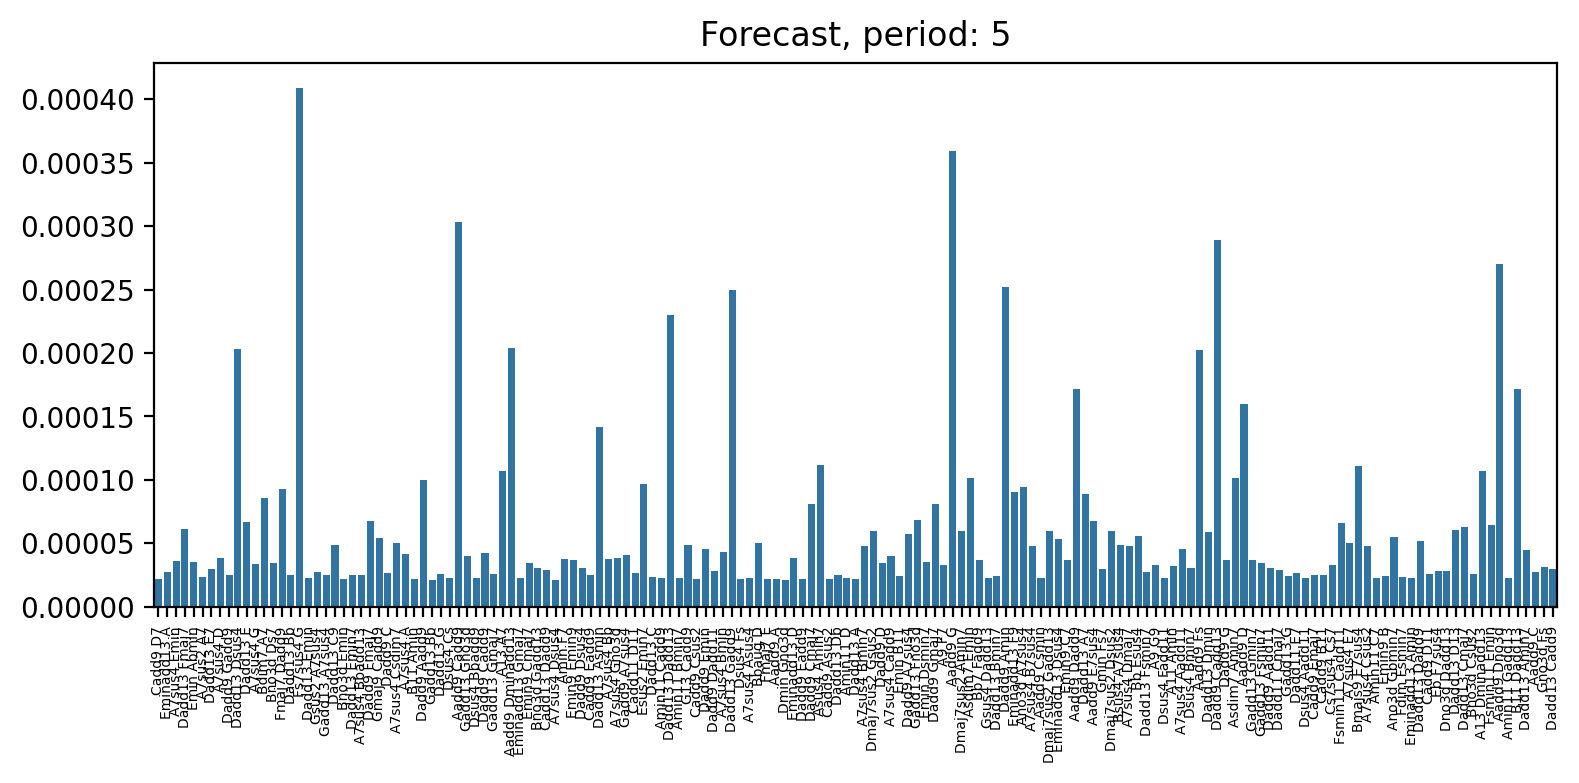

In [ ]:
# Forecasting with filtering based on axis level
np.random.seed(100)

initial_state = np.random.choice(states)
state_index = states.index(initial_state)

density = np.zeros(len(states))
density[state_index] = 1

# Plot initial 
plt.figure(figsize=(8,4))
sns.barplot(x=[initial_state], y=[1])
plt.title("Forecast: 0")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simulation
n_sim = 5
forecast = [initial_state]

for t in range(n_sim):

    # update distribution
    density = tr_pr @ density
    forecast.append(density)

    # dynamic filter: keep chords with prob ≥ 5% of max value
    max_val = density.max()
    threshold = 0.05 * max_val
    idx = np.where(density >= threshold)[0]

    plt.figure(figsize=(8,4))
    sns.barplot(
        x=np.array(states)[idx],
        y=density[idx]
    )

    plt.title(f"Forecast, period: {t+1}")
    plt.xticks(rotation=90, fontsize=5)
    plt.tight_layout()
    plt.show()


The forecasting plots illustrate how the probability mass shifts across chord states over several simulated periods. Initially concentrated on a single chord pair, the probability distribution gradually spreads to a few highly connected states before stabilizing. This mirrors how real songs transition between a small number of harmonic centers. The concentration around recurring states indicates that once the model enters a common chord cycle, it tends to remain there which underlines the repetitive and predictable nature of many country chord progressions. 

## Question 4

In [20]:
sequence = ['G C'] # started the sequence with the two most common chords in country music

for i in range(10): # generate 10 new chord pairs with the markov model
    current_chord = sequence[-1] 
    current_index = states.index(current_chord) 
    
    probs = tr_pr[current_index] # get transition probabilities for the current cord
    
    if probs.sum() == 0: # break if no outgoing transitions
        break  
    next_chord = np.random.choice(states, p=probs/probs.sum()) # randomly choose next chord based on probabilities
    sequence.append(next_chord)

print("Generated chord sequence:")
print([str(chord) for chord in sequence])


Generated chord sequence:
['G C', 'C G', 'G C', 'Amin G', 'G Amin', 'F G', 'G F', 'F G', 'C F', 'Bb C', 'G Bb']


In [21]:
def simplify(ch): # simplifying function to be more compatible with music21 package
    ch = re.sub(r' ','', ch)
    ch = re.sub(r'_','', ch)
    ch = re.sub(r'M','', ch)
    ch = re.sub(r'b','-', ch)
    ch = re.sub(r'dim6','dim', ch)
    ch = re.sub(r'd','dim', ch)
    ch = re.sub(r'm4','m', ch)

In [22]:
stream = music21.stream.Stream()

for chord_symbol in sequence:
    chords = chord_symbol.split()

    for ch in chords:
        chord = simplify(ch)
        try:
            chord = music21.harmony.ChordSymbol(ch)
            chord.duration = music21.duration.Duration(2.0)
            stream.append(chord)
        except ValueError:
            print(f"Skipping invalid chord: {ch}")
            continue
stream.write('midi', fp='music.mid')
stream.show('midi')

Skipping invalid chord: Bb
Skipping invalid chord: Bb


## Question 5: Sequence Generation Evaluation  

The chord sequences we generated with the Markov model do a pretty good job of capturing the short-term patterns you’d expect in country songs. For example, common transitions like G → C or D → G appear naturally, which shows that the model learned the local relationships between chords. Listening to or visualizing these sequences, they sound somewhat realistic over short stretches. We chose to start sequences with G and C because these are the most frequent chords in the dataset and in country music overall. This choice helps the model produce smoother, more natural progressions right from the start, instead of starting with a rare chord that could lead to unrealistic transitions. It also reflects the tonal “center” that most country songs are built around, where G and C act as core harmonic anchors.

However, the model struggles with the larger structure of a song. Real songs have verses, choruses, and long-range patterns that create tension and release, but a simple first- or second-order Markov model only looks one or two chords ahead. As a result, generated sequences can feel repetitive, wander without direction, or loop back too predictably. The estimates for common chords are reliable because they are backed by thousands of examples, but transitions involving rare or unusual chords are based on limited data, which adds uncertainty. Overall, the model captures local harmonic behavior well and produces chord patterns typical of country music, but it doesn’t capture the full musical structure that makes a song feel complete.

## Question 6: Limitations and Future Work

Our Markov model does a good job capturing the short-term patterns between chords, but it struggles with the bigger picture of a song, like verses, choruses, and bridges, which are crucial for making music feel complete. It also ignores things like rhythm, melody, and dynamics, which really shape how we perceive a song. In our simulations, chords are played at steady intervals on a piano, which isn’t how most songs actually sound. On top of that, some chord labels in the dataset are inconsistent, and transitions involving rare or unusual chords come from very few examples, so there’s some uncertainty in the results. In the future, we could try higher-order Markov models or even sequence-based approaches like LSTMs or Transformers to better capture long-term patterns. Adding rhythm and melody would make the generated music feel more realistic, and looking at specific artists or sub-genres could reveal interesting differences in how chords are used. Finally, if we model the overall structure of songs, our generated progressions could not only make harmonic sense but also feel like real songs from start to finish. 